In [19]:
%load_ext autoreload
%autoreload 2

import mido
mid = mido.MidiFile('data/midis/Aaron, Michael, Piano Course, V8WvKK-1b2c.mid', clip=True)
mid.tracks

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[MidiTrack([
   MetaMessage('set_tempo', tempo=500000, time=0),
   MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
   MetaMessage('end_of_track', time=1)]),
 MidiTrack([
   Message('note_on', channel=0, note=72, velocity=71, time=702),
   Message('note_on', channel=0, note=60, velocity=76, time=0),
   Message('control_change', channel=0, control=64, value=127, time=104),
   Message('note_on', channel=0, note=60, velocity=0, time=322),
   Message('note_on', channel=0, note=62, velocity=74, time=3),
   Message('note_on', channel=0, note=60, velocity=61, time=2),
   Message('control_change', channel=0, control=64, value=0, time=31),
   Message('note_on', channel=0, note=60, velocity=0, time=8),
   Message('note_on', channel=0, note=72, velocity=0, time=18),
   Message('note_on', channel=0, note=72, velocity=70, time=359),
   Message('note_on', channel=0, note=60, velocity=76, time=3),
   Message('note_on', channel=0, n

In [47]:
import string
import numpy as np

In [48]:
def msg2dict(msg):
    result = {}
    if 'note_on' in msg:
        on_ = True
    elif 'note_off' in msg:
        on_ = False
    else:
        on_ = None
    result['time'] = int(msg[msg.rfind('time'):].split(' ')[0].split('=')[1].translate(
        str.maketrans({a: None for a in string.punctuation})))

    if on_ is not None:
        for k in ['note', 'velocity']:
            result[k] = int(msg[msg.rfind(k):].split(' ')[0].split('=')[1].translate(
                str.maketrans({a: None for a in string.punctuation})))
    return [result, on_]

In [49]:
def switch_note(last_state, note, velocity, on_=True):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of this range will be ignored
    result = [0] * 88 if last_state is None else last_state.copy()
    if 21 <= note <= 108:
        result[note-21] = velocity if on_ else 0
    return result

In [50]:
def get_new_state(new_msg, last_state):
    new_msg, on_ = msg2dict(str(new_msg))
    new_state = switch_note(last_state, note=new_msg['note'], velocity=new_msg['velocity'], on_=on_) if on_ is not None else last_state
    return [new_state, new_msg['time']]
def track2seq(track):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of the id range will be ignored
    result = []
    last_state, last_time = get_new_state(str(track[0]), [0]*88)
    for i in range(1, len(track)):
        new_state, new_time = get_new_state(track[i], last_state)
        if new_time > 0:
            result += [last_state]*new_time
        last_state, last_time = new_state, new_time
    return result

In [51]:
def mid2arry(mid, min_msg_pct=0.1):
    tracks_len = [len(tr) for tr in mid.tracks]
    min_n_msg = max(tracks_len) * min_msg_pct
    # convert each track to nested list
    all_arys = []
    for i in range(len(mid.tracks)):
        if len(mid.tracks[i]) > min_n_msg:
            ary_i = track2seq(mid.tracks[i])
            all_arys.append(ary_i)
    # make all nested list the same length
    max_len = max([len(ary) for ary in all_arys])
    for i in range(len(all_arys)):
        if len(all_arys[i]) < max_len:
            all_arys[i] += [[0] * 88] * (max_len - len(all_arys[i]))
    all_arys = np.array(all_arys)
    all_arys = all_arys.max(axis=0)
    # trim: remove consecutive 0s in the beginning and at the end
    sums = all_arys.sum(axis=1)
    ends = np.where(sums > 0)[0]
    return all_arys[min(ends): max(ends)]

In [54]:
myarray=mid2arry(mid)

In [56]:
myarray.shape

(1194185, 88)

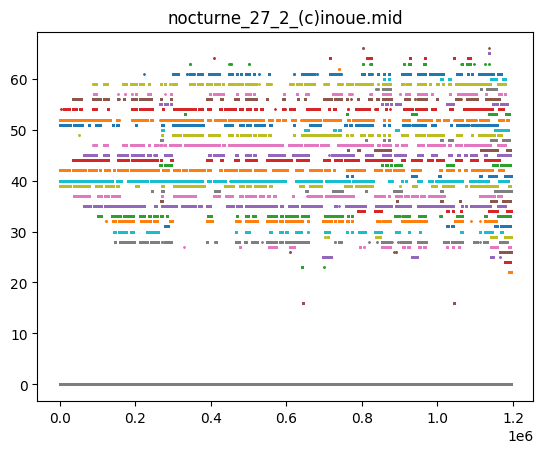

In [53]:
result_array = mid2arry(mid)
import matplotlib.pyplot as plt
plt.plot(range(result_array.shape[0]), np.multiply(np.where(result_array>0, 1, 0), range(1, 89)), marker='.', markersize=1, linestyle='')
plt.title("nocturne_27_2_(c)inoue.mid")
plt.show()